# Build input for GHAST & Analyze the generated security reports.

## Build input

In [2]:
import pandas as pd
import json
from dateutil import parser

wf_df = pd.read_csv('./data/dataframe_current_wfs_raw_cleaned.csv.gz',index_col=0)

In [41]:
def build_workflow_contents_for_GHAST(wf_list, time_list, output_path):
    
    yaml_content = []

    for time, wf in zip(time_list, wf_list):
        wf = wf.strip("\ufeff")
        yaml_content.append(f"{time}\n{wf}\n___WORKFLOW END___\n")

    with open(output_path, "w") as file:
        for wf in yaml_content:
            file.write(wf)

In [42]:
wf_list_c = wf_df['workflow_yaml'].to_list()
time_list_c = wf_df['lastCommit'].to_list()
wf_list_o = wf_df['old_workflow_yaml'].to_list()
time_list_o = wf_df['old_lastCommit'].to_list()

output_path_c = "./GHAST-main/experiments/results/workflows_all_c.yml"
output_path_o = "./GHAST-main/experiments/results/workflows_all_o.yml"

build_workflow_contents_for_GHAST(wf_list_c, time_list_o, output_path_c)
build_workflow_contents_for_GHAST(wf_list_o, time_list_o, output_path_o)

## Extract information from the security reports.

In [3]:
def load_wf_results(wf_results_path):
    
    with open(wf_results_path, 'r') as file:
        wf_results = json.load(file)
        
    return wf_results

wf_results_c = load_wf_results('./GHAST-main/experiments/results/_report_c.json')
wf_results_o = load_wf_results('./GHAST-main/experiments/results/_report_o.json')

In [25]:
def generate_analytic_results(results):
    '''
    This function extracts information from the security reports generated by GHAST and create two separate dictionaries:
    
    event_dict: This one includes the trigger events with their exploitability score [1,2,3] and the occur frequency in the dataset.
    final_results: This one includes information extracted per workflow for futher analysis.
    '''
    
    all_issue_types = ['SECRET_OUT_ENV','ACTOR', 'PULL_REQUEST_TITLE', 'PULL_REQUEST_BODY', 'NO_PINNING', 'NO_DECLARATION']
    pure_results = []
    for wf in results:
        for v in wf.values():
            pure_results.append(v)
        
    final_results = []    
    event_dict = {}
    
    for index,wf in enumerate(pure_results):

        final = {}
        ex_score = 0
        
        for event in wf['events']:
            
            if event[0] not in event_dict:
                event_dict[event[0]] = [event[1],1]
            else:
                event_dict[event[0]][1] += 1
                
            current_ex_score = event[1]
            if current_ex_score > ex_score:
                ex_score = current_ex_score


        jobs_with_issue = []
        actions_with_issue = []
        issue_types = {}
        num_issues = 0
        num_types = 0
                
        for issue in wf['issues']:              
            
            job_name = issue[0]
            issue_name = issue[-1]
            
            if job_name not in jobs_with_issue:
                
                if issue_name == 'NO_DECLARATION':
                    if issue_name not in issue_types:
                        jobs_with_issue.append(job_name)

                elif issue_name != 'ONLY_WF_DECLARATION':
                    jobs_with_issue.append(job_name)
                

            if issue_name == 'NO_PINNING':

                action_name = issue[1]
                actions_with_issue.append(action_name)
            
            if issue_name not in issue_types:
                issue_types[issue_name] = 1
            elif issue_name != 'NO_DECLARATION':
                issue_types[issue_name] += 1
        
        for issue in issue_types:
            if issue in all_issue_types:
                num_issues += issue_types[issue]
                num_types += 1 
            
        final['event_score'] = ex_score
        final['number_jobs_with_issue'] = len(jobs_with_issue)
        final['number_actions_with_issue'] = len(actions_with_issue)
        final['number_types_of_issue'] = num_types
        final['issue_types'] = issue_types
        final['number_issues'] = num_issues

        final_results.append(final)
        event_dict = dict(sorted(event_dict.items(), key=lambda item: item[1][0], reverse=True))
        
    return event_dict,final_results

event_dict_c, final_results_c = generate_analytic_results(wf_results_c)
event_dict_o, final_results_o = generate_analytic_results(wf_results_o)

In [26]:
def count_event(event_dict):
    
    event_n = 0
    for event in event_dict:
        event_n += event_dict[event][1]
        
    return event_n

event_number_c = count_event(event_dict_c)
event_number_o = count_event(event_dict_o)

print(f"{event_number_c} events used in the workflows. (Current wfs)")
print(f"{event_number_o} events used in the workflows. (Old wfs)")

33426 events used in the workflows. (Current wfs)
32127 events used in the workflows. (Old wfs)


In [27]:
def count_issue_free_wf(results):
    
    count = 0
    for wf in results:
        if wf['number_jobs_with_issue'] == 0:
            count += 1
            
    return count

issue_free_wf_c = count_issue_free_wf(final_results_c)
issue_free_wf_o = count_issue_free_wf(final_results_o)

print(f"{issue_free_wf_c} workflows are issue-free. (Current wfs)")
print(f"{issue_free_wf_o} workflows are issue-free. (Old wfs)")

3283 workflows are issue-free. (Current wfs)
1938 workflows are issue-free. (Old wfs)


## Compute the p-value on number of issues per wf for each issue type.

In [28]:
from scipy.stats import wilcoxon

def analyze_p_value(final_results):
    
    list_secrets = []
    list_github = []
    list_action = []
    list_permission = []
    
    for wf in final_results:
        
        if 'SECRET_OUT_ENV' in wf['issue_types']:
            list_secrets.append(wf['issue_types']['SECRET_OUT_ENV'])
        else:
            list_secrets.append(0)
            
        if 'ACTOR' in wf['issue_types']:
            list_github.append(wf['issue_types']['ACTOR'])
        elif 'PULL_REQUEST_TITLE' in wf['issue_types']:
            list_github.append(wf['issue_types']['PULL_REQUEST_TITLE'])
        elif 'PULL_REQUEST_BODY' in wf['issue_types']:
            list_github.append(wf['issue_types']['PULL_REQUEST_BODY'])
        else:
            list_github.append(0)
            
        if 'NO_PINNING' in wf['issue_types']:
            list_action.append(wf['issue_types']['NO_PINNING'])
        else: 
            list_action.append(0)
            
        if 'NO_DECLARATION' in wf['issue_types']:
            list_permission.append(wf['issue_types']['NO_DECLARATION'])
        else:
            list_permission.append(0)
            
    return list_secrets, list_github, list_action, list_permission

list_secrets_c, list_github_c, list_action_c, list_permission_c = analyze_p_value(final_results_c)
list_secrets_o, list_github_o, list_action_o, list_permission_o = analyze_p_value(final_results_o)

In [29]:
n = 18945

results_secrets = wilcoxon(list_secrets_c, list_secrets_o, method = 'approx')
results_github = wilcoxon(list_github_c, list_github_o, method = 'approx')
results_action = wilcoxon(list_action_c, list_action_o, method = 'approx')
results_permission = wilcoxon(list_permission_c, list_permission_o, method = 'approx')

p_value_secrets,stat_secrets = results_secrets.pvalue,results_secrets.zstatistic
p_value_github,stat_github = results_github.pvalue,results_github.zstatistic
p_value_action,stat_action = results_action.pvalue,results_action.zstatistic
p_value_permission,stat_permission = results_permission.pvalue,results_permission.zstatistic
# Output the results
r_secrets = abs(stat_secrets / (n ** 0.5))
r_github = abs(stat_github / (n ** 0.5))
r_action = abs(stat_action / (n ** 0.5))
r_permission = abs(stat_permission / (n ** 0.5))

print(f"P-value: {p_value_secrets:.3f}; Effect size: {r_secrets: .3f} (Confidential Data Disclosure)")
print(f"P-value: {p_value_github:.3f}; Effect size: {r_github: .3f} (Command Injection)")
print(f"P-value: {p_value_action:.3f}; Effect size: {r_action: .3f} (Unverified Action Version Unpinned)")
print(f"P-value: {p_value_permission: .3f}; Effect size: {r_permission: .3f} (No Permissions Specified)")

P-value: 0.355; Effect size:  0.007 (Confidential Data Disclosure)
P-value: 0.523; Effect size:  0.005 (Command Injection)
P-value: 0.074; Effect size:  0.013 (Unverified Action Version Unpinned)
P-value:  0.000; Effect size:  0.170 (No Permissions Specified)


In [30]:
list_vulnerability_c = [i+j for i,j in zip(list_secrets_c, list_github_c)]
list_vulnerability_o = [i+j for i,j in zip(list_secrets_o, list_github_o)]
list_misconfiguration_c = [i+j for i,j in zip(list_action_c, list_permission_c)]
list_misconfiguration_o = [i+j for i,j in zip(list_action_o, list_permission_o)]

In [31]:
results_vulnerability = wilcoxon(list_vulnerability_c, list_vulnerability_o, method = 'approx')
results_misconfiguration = wilcoxon(list_misconfiguration_c, list_misconfiguration_o, method = 'approx')

p_value_vulnerability,stat_vulnerability = results_vulnerability.pvalue,results_vulnerability.zstatistic
p_value_misconfiguration,stat_misconfiguration = results_misconfiguration.pvalue,results_misconfiguration.zstatistic

r_vulnerability = abs(stat_vulnerability / (n ** 0.5))
r_misconfiguration = abs(stat_misconfiguration / (n ** 0.5))

print(f"P-value: {p_value_vulnerability:.3f}; Effect size: {r_vulnerability: .3f}; (Vulnerabilities)")
print(f"P-value: {p_value_misconfiguration: .3f}; Effect size: {r_misconfiguration: .3f}; (Misconfigurations)")

P-value: 0.320; Effect size:  0.007; (Vulnerabilities)
P-value:  0.000; Effect size:  0.069; (Misconfigurations)


In [32]:
list_issues_c = [i+j for i,j in zip(list_vulnerability_c, list_misconfiguration_c)]
list_issues_o = [i+j for i,j in zip(list_vulnerability_o, list_misconfiguration_o)]
results_issues= wilcoxon(list_issues_c, list_issues_o, method = 'approx')
p_value_issues,stat_issues = results_issues.pvalue,results_issues.zstatistic
r_issues = abs(stat_issues / (n ** 0.5))
print(f"P-value: {p_value_issues: .3f}; Effect size: {r_issues: .3f}; (All issues)")

P-value:  0.000; Effect size:  0.062; (All issues)


## Count issues for each issue type according to wf's security level.

In [33]:
type_secret = ['SECRET_OUT_ENV']
type_injection = ['ACTOR', 'PULL_REQUEST_TITLE', 'PULL_REQUEST_BODY']
type_action = ['NO_PINNING']
type_permission = ['NO_DECLARATION']

def analyze_issues_per_job(final_results, issue_type):
    
    wf_w_issue_all = 0
    wf_w_issue_1 = 0
    wf_w_issue_2 = 0
    wf_w_issue_3 = 0
     
    for wf in final_results:
        
        for issue in issue_type:
            
            if issue in wf['issue_types']:
                wf_w_issue_all += wf['issue_types'][issue]

                if wf['event_score'] == 1:
                    wf_w_issue_1 += wf['issue_types'][issue]
                elif wf['event_score'] == 2:
                    wf_w_issue_2 += wf['issue_types'][issue]
                else:
                    wf_w_issue_3 += wf['issue_types'][issue]
    
    wf_w_issue = (wf_w_issue_all,wf_w_issue_1,wf_w_issue_2,wf_w_issue_3)
    
    return wf_w_issue

In [34]:
type_vulnerability = ['SECRET_OUT_ENV','ACTOR', 'PULL_REQUEST_TITLE', 'PULL_REQUEST_BODY']
type_misconfiguration = ['NO_PINNING','NO_DECLARATION']
type_all = type_vulnerability + type_misconfiguration

def analyze_issues_per_wf(final_results, issue_type):
    
    wf_w_issue_all = 0
    wf_w_issue_1 = 0
    wf_w_issue_2 = 0
    wf_w_issue_3 = 0
    
    
    for wf in final_results:
        
        for issue in issue_type:
            
            if issue in wf['issue_types']:
                wf_w_issue_all += 1

                if wf['event_score'] == 1:
                    wf_w_issue_1 += 1
                elif wf['event_score'] == 2:
                    wf_w_issue_2 += 1
                else:
                    wf_w_issue_3 += 1
                    
                break
    
    wf_w_issue = (wf_w_issue_all,wf_w_issue_1,wf_w_issue_2,wf_w_issue_3)
    
    return wf_w_issue

In [35]:
wf_w_secret_wf_c = analyze_issues_per_wf(final_results_c, type_secret)
wf_w_secret_wf_o = analyze_issues_per_wf(final_results_o, type_secret)
wf_w_secret_job_c = analyze_issues_per_job(final_results_c, type_secret)
wf_w_secret_job_o = analyze_issues_per_job(final_results_o, type_secret)

print("*** Confidential Data Disclosure ***")
print("- Wf level -")
print(f"All issues: {wf_w_secret_wf_c[0]}; E.S. = 1: {wf_w_secret_wf_c[1]}; E.S. = 2: {wf_w_secret_wf_c[2]}; E.S. = 3: {wf_w_secret_wf_c[3]} (Current wfs)")
print(f"All issues: {wf_w_secret_wf_o[0]}; E.S. = 1: {wf_w_secret_wf_o[1]}; E.S. = 2: {wf_w_secret_wf_o[2]}; E.S. = 3: {wf_w_secret_wf_o[3]} (Old wfs)")
print("- Job level -")
print(f"All issues: {wf_w_secret_job_c[0]}; E.S. = 1: {wf_w_secret_job_c[1]}; E.S. = 2: {wf_w_secret_job_c[2]}; E.S. = 3: {wf_w_secret_job_c[3]} (Current wfs)")
print(f"All issues: {wf_w_secret_job_o[0]}; E.S. = 1: {wf_w_secret_job_o[1]}; E.S. = 2: {wf_w_secret_job_o[2]}; E.S. = 3: {wf_w_secret_job_o[3]} (Old wfs)")

*** Confidential Data Disclosure ***
- Wf level -
All issues: 1138; E.S. = 1: 727; E.S. = 2: 385; E.S. = 3: 26 (Current wfs)
All issues: 1121; E.S. = 1: 756; E.S. = 2: 335; E.S. = 3: 30 (Old wfs)
- Job level -
All issues: 2617; E.S. = 1: 1786; E.S. = 2: 779; E.S. = 3: 52 (Current wfs)
All issues: 2345; E.S. = 1: 1584; E.S. = 2: 707; E.S. = 3: 54 (Old wfs)


In [36]:
wf_w_code_injection_wf_c = analyze_issues_per_wf(final_results_c, type_injection)
wf_w_code_injection_wf_o = analyze_issues_per_wf(final_results_o, type_injection)
wf_w_code_injection_job_c = analyze_issues_per_job(final_results_c, type_injection)
wf_w_code_injection_job_o = analyze_issues_per_job(final_results_o, type_injection)

print("*** Command Injection ***")
print("- Wf level -")
print(f"All issues: {wf_w_code_injection_wf_c[0]}; E.S. = 1: {wf_w_code_injection_wf_c[1]}; E.S. = 2: {wf_w_code_injection_wf_c[2]}; E.S. = 3: {wf_w_code_injection_wf_c[3]} (Current wfs)")
print(f"All issues: {wf_w_code_injection_wf_o[0]}; E.S. = 1: {wf_w_code_injection_wf_o[1]}; E.S. = 2: {wf_w_code_injection_wf_o[2]}; E.S. = 3: {wf_w_code_injection_wf_o[3]} (Old wfs)")
print("- Job level -")
print(f"All issues: {wf_w_code_injection_job_c[0]}; E.S. = 1: {wf_w_code_injection_job_c[1]}; E.S. = 2: {wf_w_code_injection_job_c[2]}; E.S. = 3: {wf_w_code_injection_job_c[3]} (Current wfs)")
print(f"All issues: {wf_w_code_injection_job_o[0]}; E.S. = 1: {wf_w_code_injection_job_o[1]}; E.S. = 2: {wf_w_code_injection_job_o[2]}; E.S. = 3: {wf_w_code_injection_job_o[3]} (Old wfs)")

*** Command Injection ***
- Wf level -
All issues: 101; E.S. = 1: 72; E.S. = 2: 28; E.S. = 3: 1 (Current wfs)
All issues: 86; E.S. = 1: 66; E.S. = 2: 20; E.S. = 3: 0 (Old wfs)
- Job level -
All issues: 114; E.S. = 1: 78; E.S. = 2: 35; E.S. = 3: 1 (Current wfs)
All issues: 102; E.S. = 1: 74; E.S. = 2: 28; E.S. = 3: 0 (Old wfs)


In [37]:
wf_w_action_wf_c = analyze_issues_per_wf(final_results_c, type_action)
wf_w_action_wf_o = analyze_issues_per_wf(final_results_o, type_action)
wf_w_action_job_c = analyze_issues_per_job(final_results_c, type_action)
wf_w_action_job_o = analyze_issues_per_job(final_results_o, type_action)
print("*** Unverified Action Version Unpinned ***")
print("- Wf level -")
print(f"All issues: {wf_w_action_wf_c[0]}; E.S. = 1: {wf_w_action_wf_c[1]}; E.S. = 2: {wf_w_action_wf_c[2]}; E.S. = 3: {wf_w_action_wf_c[3]} (Current wfs)")
print(f"All issues: {wf_w_action_wf_o[0]}; E.S. = 1: {wf_w_action_wf_o[1]}; E.S. = 2: {wf_w_action_wf_o[2]}; E.S. = 3: {wf_w_action_wf_o[3]} (Old wfs)")
print("- Job level -")
print(f"All issues: {wf_w_action_job_c[0]}; E.S. = 1: {wf_w_action_job_c[1]}; E.S. = 2: {wf_w_action_job_c[2]}; E.S. = 3: {wf_w_action_job_c[3]} (Current wfs)")
print(f"All issues: {wf_w_action_job_o[0]}; E.S. = 1: {wf_w_action_job_o[1]}; E.S. = 2: {wf_w_action_job_o[2]}; E.S. = 3: {wf_w_action_job_o[3]} (Old wfs)")

*** Unverified Action Version Unpinned ***
- Wf level -
All issues: 7500; E.S. = 1: 3112; E.S. = 2: 3975; E.S. = 3: 413 (Current wfs)
All issues: 7929; E.S. = 1: 3383; E.S. = 2: 4086; E.S. = 3: 460 (Old wfs)
- Job level -
All issues: 16439; E.S. = 1: 5947; E.S. = 2: 9815; E.S. = 3: 677 (Current wfs)
All issues: 16146; E.S. = 1: 6236; E.S. = 2: 9121; E.S. = 3: 789 (Old wfs)


In [38]:
wf_w_permission_wf_c = analyze_issues_per_wf(final_results_c, type_permission)
wf_w_permission_wf_o = analyze_issues_per_wf(final_results_o, type_permission)
wf_w_permission_job_c = analyze_issues_per_job(final_results_c, type_permission)
wf_w_permission_job_o = analyze_issues_per_job(final_results_o, type_permission)
print("*** No Permissions Specified ***")
print("- Wf level -")
print(f"All issues: {wf_w_permission_wf_c[0]}; E.S. = 1: {wf_w_permission_wf_c[1]}; E.S. = 2: {wf_w_permission_wf_c[2]}; E.S. = 3: {wf_w_permission_wf_c[3]} (Current wfs)")
print(f"All issues: {wf_w_permission_wf_o[0]}; E.S. = 1: {wf_w_permission_wf_o[1]}; E.S. = 2: {wf_w_permission_wf_o[2]}; E.S. = 3: {wf_w_permission_wf_o[3]} (Old wfs)")
print("- Job level -")
print(f"All issues: {wf_w_permission_job_c[0]}; E.S. = 1: {wf_w_permission_job_c[1]}; E.S. = 2: {wf_w_permission_job_c[2]}; E.S. = 3: {wf_w_permission_job_c[3]} (Current wfs)")
print(f"All issues: {wf_w_permission_job_o[0]}; E.S. = 1: {wf_w_permission_job_o[1]}; E.S. = 2: {wf_w_permission_job_o[2]}; E.S. = 3: {wf_w_permission_job_o[3]} (Old wfs)")

*** No Permissions Specified ***
- Wf level -
All issues: 14192; E.S. = 1: 5522; E.S. = 2: 8081; E.S. = 3: 589 (Current wfs)
All issues: 16036; E.S. = 1: 6385; E.S. = 2: 8958; E.S. = 3: 693 (Old wfs)
- Job level -
All issues: 14192; E.S. = 1: 5522; E.S. = 2: 8081; E.S. = 3: 589 (Current wfs)
All issues: 16036; E.S. = 1: 6385; E.S. = 2: 8958; E.S. = 3: 693 (Old wfs)


In [39]:
wf_w_vulnerabilities_wf_c = analyze_issues_per_wf(final_results_c, type_vulnerability)
wf_w_vulnerabilities_wf_o = analyze_issues_per_wf(final_results_o, type_vulnerability)
wf_w_vulnerabilities_job_c = analyze_issues_per_job(final_results_c, type_vulnerability)
wf_w_vulnerabilities_job_o = analyze_issues_per_job(final_results_o, type_vulnerability)
print("*** All Vulnerabilities ***")
print("- Wf level -")
print(f"All issues: {wf_w_vulnerabilities_wf_c[0]}; E.S. = 1: {wf_w_vulnerabilities_wf_c[1]}; E.S. = 2: {wf_w_vulnerabilities_wf_c[2]}; E.S. = 3: {wf_w_vulnerabilities_wf_c[3]} (Current wfs)")
print(f"All issues: {wf_w_vulnerabilities_wf_o[0]}; E.S. = 1: {wf_w_vulnerabilities_wf_o[1]}; E.S. = 2: {wf_w_vulnerabilities_wf_o[2]}; E.S. = 3: {wf_w_vulnerabilities_wf_o[3]} (Old wfs)")
print("- Job level -")
print(f"All issues: {wf_w_vulnerabilities_job_c[0]}; E.S. = 1: {wf_w_vulnerabilities_job_c[1]}; E.S. = 2: {wf_w_vulnerabilities_job_c[2]}; E.S. = 3: {wf_w_vulnerabilities_job_c[3]} (Current wfs)")
print(f"All issues: {wf_w_vulnerabilities_job_o[0]}; E.S. = 1: {wf_w_vulnerabilities_job_o[1]}; E.S. = 2: {wf_w_vulnerabilities_job_o[2]}; E.S. = 3: {wf_w_vulnerabilities_job_o[3]} (Old wfs)")

*** All Vulnerabilities ***
- Wf level -
All issues: 1185; E.S. = 1: 760; E.S. = 2: 399; E.S. = 3: 26 (Current wfs)
All issues: 1159; E.S. = 1: 783; E.S. = 2: 346; E.S. = 3: 30 (Old wfs)
- Job level -
All issues: 2731; E.S. = 1: 1864; E.S. = 2: 814; E.S. = 3: 53 (Current wfs)
All issues: 2447; E.S. = 1: 1658; E.S. = 2: 735; E.S. = 3: 54 (Old wfs)


In [40]:
wf_w_misconfigurations_wf_c = analyze_issues_per_wf(final_results_c, type_misconfiguration)
wf_w_misconfigurations_wf_o = analyze_issues_per_wf(final_results_o, type_misconfiguration)
wf_w_misconfigurations_job_c = analyze_issues_per_job(final_results_c, type_misconfiguration)
wf_w_misconfigurations_job_o = analyze_issues_per_job(final_results_o, type_misconfiguration)
print("*** All Misconfigirations ***")
print("- Wf level -")
print(f"All issues: {wf_w_misconfigurations_wf_c[0]}; E.S. = 1: {wf_w_misconfigurations_wf_c[1]}; E.S. = 2: {wf_w_misconfigurations_wf_c[2]}; E.S. = 3: {wf_w_misconfigurations_wf_c[3]} (Current wfs)")
print(f"All issues: {wf_w_misconfigurations_wf_o[0]}; E.S. = 1: {wf_w_misconfigurations_wf_o[1]}; E.S. = 2: {wf_w_misconfigurations_wf_o[2]}; E.S. = 3: {wf_w_misconfigurations_wf_o[3]} (Old wfs)")
print("- Job level -")
print(f"All issues: {wf_w_misconfigurations_job_c[0]}; E.S. = 1: {wf_w_misconfigurations_job_c[1]}; E.S. = 2: {wf_w_misconfigurations_job_c[2]}; E.S. = 3: {wf_w_misconfigurations_job_c[3]} (Current wfs)")
print(f"All issues: {wf_w_misconfigurations_job_o[0]}; E.S. = 1: {wf_w_misconfigurations_job_o[1]}; E.S. = 2: {wf_w_misconfigurations_job_o[2]}; E.S. = 3: {wf_w_misconfigurations_job_o[3]} (Old wfs)")

*** All Misconfigirations ***
- Wf level -
All issues: 15526; E.S. = 1: 6047; E.S. = 2: 8775; E.S. = 3: 704 (Current wfs)
All issues: 16920; E.S. = 1: 6731; E.S. = 2: 9436; E.S. = 3: 753 (Old wfs)
- Job level -
All issues: 30631; E.S. = 1: 11469; E.S. = 2: 17896; E.S. = 3: 1266 (Current wfs)
All issues: 32182; E.S. = 1: 12621; E.S. = 2: 18079; E.S. = 3: 1482 (Old wfs)


In [41]:
wf_w_all_wf_c = analyze_issues_per_wf(final_results_c, type_all)
wf_w_all_wf_o = analyze_issues_per_wf(final_results_o, type_all)
wf_w_all_job_c = analyze_issues_per_job(final_results_c, type_all)
wf_w_all_job_o = analyze_issues_per_job(final_results_o, type_all)
print("*** All Issues ***")
print("- Wf level -")
print(f"All issues: {wf_w_all_wf_c[0]}; E.S. = 1: {wf_w_all_wf_c[1]}; E.S. = 2: {wf_w_all_wf_c[2]}; E.S. = 3: {wf_w_all_wf_c[3]} (Current wfs)")
print(f"All issues: {wf_w_all_wf_o[0]}; E.S. = 1: {wf_w_all_wf_o[1]}; E.S. = 2: {wf_w_all_wf_o[2]}; E.S. = 3: {wf_w_all_wf_o[3]} (Old wfs)")
print("- Job level -")
print(f"All issues: {wf_w_all_job_c[0]}; E.S. = 1: {wf_w_all_job_c[1]}; E.S. = 2: {wf_w_all_job_c[2]}; E.S. = 3: {wf_w_all_job_c[3]} (Current wfs)")
print(f"All issues: {wf_w_all_job_o[0]}; E.S. = 1: {wf_w_all_job_o[1]}; E.S. = 2: {wf_w_all_job_o[2]}; E.S. = 3: {wf_w_all_job_o[3]} (Old wfs)")

*** All Issues ***
- Wf level -
All issues: 15655; E.S. = 1: 6136; E.S. = 2: 8812; E.S. = 3: 707 (Current wfs)
All issues: 17000; E.S. = 1: 6786; E.S. = 2: 9458; E.S. = 3: 756 (Old wfs)
- Job level -
All issues: 33362; E.S. = 1: 13333; E.S. = 2: 18710; E.S. = 3: 1319 (Current wfs)
All issues: 34629; E.S. = 1: 14279; E.S. = 2: 18814; E.S. = 3: 1536 (Old wfs)


## Visualize the distribution of the permissions used in the workflows.

In [42]:
def analyze_permission(final_results):
    
    wf_no_permission = 0
    wf_wf_permission = 0
    wf_job_permission = 0
    
    for wf in final_results:
        
        if 'NO_DECLARATION' in wf['issue_types'] or 'ONLY_WF_DECLARATION' in wf['issue_types']:
                
            if 'NO_DECLARATION' in wf['issue_types']:
                wf_no_permission += 1
            
            if 'ONLY_WF_DECLARATION' in wf['issue_types']:
                wf_wf_permission += 1
        
        else:
            
            wf_job_permission += 1
    
    return wf_no_permission, wf_wf_permission, wf_job_permission

wf_no_permission_c, wf_wf_permission_c, wf_job_permission_c = analyze_permission(final_results_c)
wf_no_permission_o, wf_wf_permission_o, wf_job_permission_o = analyze_permission(final_results_o)

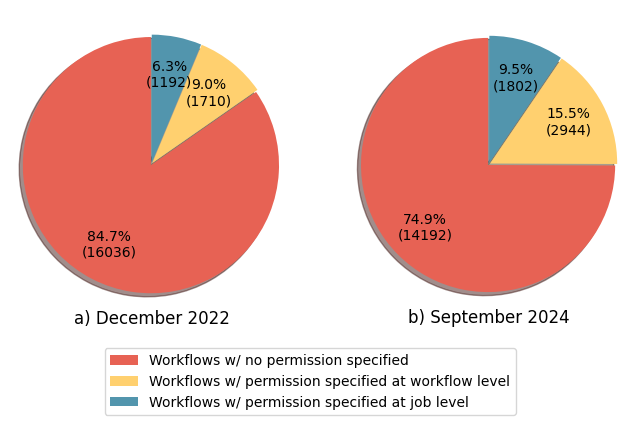

In [43]:
import matplotlib.pyplot as plt

def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{pct:.1f}%\n({val})'
    return my_format

def permission_piechart(data_1, data_2, labels, saving_path = None):
    
    colors = [
    (231/255, 98/255, 84/255),
    (255/255, 208/255, 111/255),
    (82/255, 149/255, 173/255),
    (30/255, 70/255, 110/255)
    ]
    
    explode_n = [0.01,0.01,0.01]
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))

    pie_1 = ax[0].pie(data_1, colors=colors, explode=explode_n, autopct=autopct_format(data_1), pctdistance=0.7, shadow=True, startangle=90)
    ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    #ax[0].set_title('a) December 2022')
    ax[0].text(0, -1.25, 'a) December 2022', ha='center', fontsize=12)

    pie_2 = ax[1].pie(data_2, colors=colors, explode=explode_n, autopct=autopct_format(data_2), pctdistance=0.7, shadow=True, startangle=90)
    ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    #ax[1].set_title('b) September 2024')
    ax[1].text(0, -1.25, 'b) September 2024', ha='center', fontsize=12)
    
    fig.legend(pie_2[0], labels, loc='lower center', ncol=1, bbox_to_anchor=(0.5, -0.15))
    
    
    if saving_path:
        
        plt.savefig(saving_path, format='pdf', bbox_inches='tight')
    
    plt.show()
    return
    
sept_2024 = [wf_no_permission_c, wf_wf_permission_c, wf_job_permission_c]
dec_2022 = [wf_no_permission_o, wf_wf_permission_o, wf_job_permission_o]
labels = ['Workflows w/ no permission specified', 'Workflows w/ permission specified at workflow level', 'Workflows w/ permission specified at job level']
saving_path = './plots/permission_comparison.pdf'

permission_piechart(dec_2022,sept_2024,labels,saving_path)

## Compare issues found in 2022 and 2024 versions of the workflows.

In [45]:
def compare_results(final_results, old_final_results):
    
    compared_results = []
    current_results = []
    old_results = []
    
    for result, old_result in zip(final_results, old_final_results):
        compared = {}
        
        compared['event_score'] = result['event_score'] - old_result['event_score']
        compared['number_jobs_with_issue'] = result['number_jobs_with_issue'] - old_result['number_jobs_with_issue']
        compared['number_actions_with_issue'] = result['number_actions_with_issue'] - old_result['number_actions_with_issue']
        compared['number_types_of_issue'] = result['number_types_of_issue'] - old_result['number_types_of_issue']
        compared['number_issues'] = result['number_issues'] - old_result['number_issues']

        
        compared_results.append(compared)

    
    df_compared_results = pd.DataFrame(compared_results)
    df_current_results = pd.DataFrame(final_results)
    df_old_results = pd.DataFrame(old_final_results)
    
    print(f"*** Current wfs ***")
    #print(f"Total exploitability score: {sum(df_current_results['event_score'].to_list())}")
    print(f"Number of jobs with issue: {sum(df_current_results['number_jobs_with_issue'].tolist())}")
    print(f"Number of actions with issue: {sum(df_current_results['number_actions_with_issue'].to_list())}")
    print(f"Number of types of issues: {sum(df_current_results['number_types_of_issue'].to_list())}")
    print(f"Number of issues: {sum(df_current_results['number_issues'].to_list())}")
    print('')
    print(f"*** Old wfs ***")
    #print(f"Total exploitability score: {sum(df_old_results['event_score'].to_list())}")
    print(f"Number of jobs with issue: {sum(df_old_results['number_jobs_with_issue'].tolist())}")
    print(f"Number of actions with issue: {sum(df_old_results['number_actions_with_issue'].to_list())}")
    print(f"Number of types of issues: {sum(df_old_results['number_types_of_issue'].to_list())}")
    print(f"Number of issues: {sum(df_old_results['number_issues'].to_list())}")
    print('')
    print(f"*** Difference ***")
    #print(f"Exploitability score: {sum(df_compared_results['event_score'].to_list())}")
    print(f"Number of jobs with issue: {sum(df_compared_results['number_jobs_with_issue'].to_list())}")
    print(f"Number of actions with issue: {sum(df_compared_results['number_actions_with_issue'].to_list())}")
    print(f"Number of types of issue: {sum(df_compared_results['number_types_of_issue'].to_list())}")
    print(f"Number of issues: {sum(df_compared_results['number_issues'].to_list())}")
    
    return 

compared_results = compare_results(final_results_c, final_results_o)

*** Current wfs ***
Number of jobs with issue: 20795
Number of actions with issue: 16439
Number of types of issues: 22931
Number of issues: 33362

*** Old wfs ***
Number of jobs with issue: 21255
Number of actions with issue: 16146
Number of types of issues: 25172
Number of issues: 34629

*** Difference ***
Number of jobs with issue: -460
Number of actions with issue: 293
Number of types of issue: -2241
Number of issues: -1267
